In [ ]:
# default_exp data.preprocessing

# Data preprocessing

> Functions used to preprocess time series (both X and y).

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

In [ ]:
#export
class ToNumpyCategory(Transform):
    "Categorize a numpy batch"
    order = 90

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def encodes(self, o: np.ndarray):
        self.type = type(o)
        self.cat = Categorize()
        self.cat.setup(o)
        self.vocab = self.cat.vocab
        return np.asarray(stack([self.cat(oi) for oi in o]))

    def decodes(self, o: (np.ndarray, torch.Tensor)):
        return stack([self.cat.decode(oi) for oi in o])

In [ ]:
t = ToNumpyCategory()
y_cat = t(y)
y_cat[:10]

array([3, 2, 2, 3, 2, 4, 0, 5, 2, 1])

In [ ]:
test_eq(t.decode(tensor(y_cat)), y)
test_eq(t.decode(np.array(y_cat)), y)

In [ ]:
#export
class OneHot(Transform): 
    "One-hot encode/ decode a batch"
    order = 90
    def __init__(self, n_classes=None, **kwargs): 
        self.n_classes = n_classes
        super().__init__(**kwargs)
    def encodes(self, o: torch.Tensor): 
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return torch.eye(self.n_classes)[o]
    def encodes(self, o: np.ndarray): 
        o = ToNumpyCategory()(o)
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return np.eye(self.n_classes)[o]
    def decodes(self, o: torch.Tensor): return torch.argmax(o, dim=-1)
    def decodes(self, o: np.ndarray): return np.argmax(o, axis=-1)

In [ ]:
oh_encoder = OneHot()
y_cat = ToNumpyCategory()(y)
oht = oh_encoder(y_cat)
oht[:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
n_classes = 10
n_samples = 100

t = torch.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oht = oh_encoder(t)
test_eq(oht.shape, (n_samples, n_classes))
test_eq(torch.argmax(oht, dim=-1), t)
test_eq(oh_encoder.decode(oht), t)

In [ ]:
n_classes = 10
n_samples = 100

a = np.random.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oha = oh_encoder(a)
test_eq(oha.shape, (n_samples, n_classes))
test_eq(np.argmax(oha, axis=-1), a)
test_eq(oh_encoder.decode(oha), a)

In [ ]:
#export
class Nan2Value(Transform):
    "Replaces any nan values by a predefined value"
    order = 90
    def __init__(self, value=0, median=True, by_sample_and_var=False): # set to True when torch 1.8.0 is supported by fastai
        store_attr()
    def encodes(self, o:TSTensor):
        mask = torch.isnan(o)
        if mask.any():
            if not self.median:
                median = self.value
                o[mask] = median
                # return torch.nan_to_num(o, nan=self.value) # available in torch 1.8.0
            else:
                if self.by_sample_and_var:
                    median = torch.median(o, dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1])
                    # median = torch.nanmedian(o, dim=2, keepdim=True)[0].repeat(1, 1, o.shape[-1]) # available in torch 1.8.0
                    o[mask] = median[mask]
                else:
                    median = torch.median(o)
                    # median = torch.nanmedian(o) # available in torch 1.8.0
                    o[mask] = median
                # Just in case any sample or var values are all nan
                mask = torch.isnan(o)
                if mask.any(): 
                    o[mask] = self.value
        return o

In [ ]:
o = TSTensor(torch.randn(16, 10, 100))
o[0,0] = float('nan')
o[o > .9] = float('nan')
o[[0,1,5,8,14,15], :, -20:] = float('nan')
nan_vals1 = torch.isnan(o).sum()
o2 = Pipeline(Nan2Value(median=True, by_sample_and_var=True), split_idx=0)(o.clone())
nan_vals2 = torch.isnan(o2).sum()
test_ne(nan_vals1, 0)
test_eq(nan_vals2, 0)

In [ ]:
#export
class TSStandardize(Transform):
    "Standardizes batch of type `TSTensor`"
    parameters, order = L('mean', 'std'), 90
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, by_step=False, eps=1e-8, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.eps = eps
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var and not is_listy(by_var): drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        self.verbose = verbose
        if self.mean is not None or self.std is not None:
            pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', self.verbose)

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if (self.mean is None or self.std is None):
            o, *_ = dl.one_batch()
            if self.by_var and is_listy(self.by_var):
                _mean = []
                _std = []
                start = 0
                for i,v in enumerate(self.by_var):
                    if is_listy(v): f = v
                    else:
                        end = start + v
                        f = slice(start, end)
                        start += v
                    repeats = len(v) if is_listy(v) else v
                    _mean.append((torch_nanmean(o[:, f], self.axes, keepdim=True)).repeat(1, repeats, 1))
                    _std.append((torch_nanstd(o[:, f], self.axes, keepdim=True) + self.eps).repeat(1, repeats, 1))
                self.mean = torch.cat(_mean, dim=1)
                self.std = torch.clamp_min(torch.cat(_std, dim=1), self.eps)
            else: 
                self.mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                self.std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
            if len(self.mean.shape) == 0:
                pv(f'{self.__class__.__name__} mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)
            else:
                pv(f'{self.__class__.__name__} mean shape={self.mean.shape}, std shape={self.std.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n',
                   self.verbose)

    def encodes(self, o:TSTensor):
        if self.by_sample:
            if is_listy(self.by_var):
                _o = []
                start = 0
                for i,v in enumerate(self.by_var):
                    if is_listy(v): f = v
                    else:
                        end = start + v
                        f = slice(start, end)
                        start += v
                    o_mean = torch_nanmean(o[:, f], self.axes, keepdim=True)
                    o_std = torch.clamp_min(torch_nanstd(o[:, f], self.axes, keepdim=True), self.eps)
                    _o.append((o[:, f] - o_mean) / o_std)
                return torch.cat(_o, dim=1)
            else:
                self.mean = torch_nanmean(o, dim=self.axes, keepdim=self.axes!=())
                self.std = torch.clamp_min(torch_nanstd(o, dim=self.axes, keepdim=self.axes!=()), self.eps)
        return (o - self.mean) / self.std

    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
#export
@patch
def mul_min(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.min(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    min_x = x
    for ax in axes: min_x, _ = min_x.min(ax, keepdim)
    return retain_type(min_x, x)


@patch
def mul_max(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.max(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    max_x = x
    for ax in axes: max_x, _ = max_x.max(ax, keepdim)
    return retain_type(max_x, x)


class TSNormalize(Transform):
    "Normalizes batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90

    def __init__(self, min=None, max=None, range=(-1, 1), by_sample=False, by_var=False, by_step=False, verbose=False):
        self.min = tensor(min) if min is not None else None
        self.max = tensor(max) if max is not None else None
        self.range_min, self.range_max = range
        self.by_sample, self.by_var, self.by_step = by_sample, by_var, by_step
        drop_axes = []
        if by_sample: drop_axes.append(0)
        if by_var: drop_axes.append(1)
        if by_step: drop_axes.append(2)
        self.axes = tuple([ax for ax in (0, 1, 2) if ax not in drop_axes])
        self.verbose = verbose
        if self.min is not None or self.max is not None:
            pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', self.verbose)
            
    @classmethod
    def from_stats(cls, min, max, range_min=0, range_max=1): return cls(min, max, self.range_min, self.range_max)

    def setups(self, dl: DataLoader):
        if self.min is None or self.max is None:
            x, *_ = dl.one_batch()
            self.min, self.max = x.mul_min(self.axes, keepdim=self.axes!=()), x.mul_max(self.axes, keepdim=self.axes!=())
            if len(self.min.shape) == 0: 
                pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', self.verbose)
            else:
                pv(f'{self.__class__.__name__} min shape={self.min.shape}, max shape={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step}\n', 
                   self.verbose)

    def encodes(self, o:TSTensor): 
        if self.by_sample: self.min, self.max = o.mul_min(self.axes, keepdim=self.axes!=()), o.mul_max(self.axes, keepdim=self.axes!=())
        return torch.clamp(((o - self.min) / (self.max - self.min)) * (self.range_max - self.range_min) + self.range_min, 
                           self.range_min, self.range_max)
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var}, by_step={self.by_step})'

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

TSStandardize mean shape=(128, 1, 1), std shape=(128, 1, 1), by_sample=True, by_var=False, by_step=False



In [ ]:
from tsai.data.validation import TimeSplitter
X_nan = np.random.rand(100, 5, 10)
idxs = np.random.choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 0] = float('nan')
idxs = np.random.choice(len(X_nan), int(len(X_nan)*.5), False)
X_nan[idxs, 1, -10:] = float('nan')
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
test_eq(torch.isnan(dls.after_batch[0].mean).sum(), 0)
test_eq(torch.isnan(dls.after_batch[0].std).sum(), 0)
xb = first(dls.train)[0]
test_ne(torch.isnan(xb).sum(), 0)
test_ne(torch.isnan(xb).sum(), torch.isnan(xb).numel())
batch_tfms = [TSStandardize(by_var=True), Nan2Value()]
dls = get_ts_dls(X_nan, batch_tfms=batch_tfms, splits=TimeSplitter(show_plot=False)(range_of(X_nan)))
xb = first(dls.train)[0]
test_eq(torch.isnan(xb).sum(), 0)

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
batch_tfms=[TSNormalize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)

In [ ]:
#export
class TSClipOutliers(Transform):
    "Clip outliers batch of type `TSTensor` based on the IQR"
    parameters, order = L('min', 'max'), 90
    def __init__(self, min=None, max=None, by_sample=False, by_var=False, verbose=False):
        self.su = (min is None or max is None) and not by_sample 
        self.min = tensor(min) if min is not None else tensor(-np.inf)
        self.max = tensor(max) if max is not None else tensor(np.inf)
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axis = (2)
        elif by_sample: self.axis = (1, 2)
        elif by_var: self.axis = (0, 2)
        else: self.axis = None
        self.verbose = verbose
        if min is not None or max is not None:
            pv(f'{self.__class__.__name__} min={min}, max={max}\n', self.verbose)

    def setups(self, dl: DataLoader):
        if self.su:
            o, *_ = dl.one_batch()
            min, max = get_outliers_IQR(o, self.axis)
            self.min, self.max = tensor(min), tensor(max)
            if self.axis is None: pv(f'{self.__class__.__name__} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                                     self.verbose)
            else: pv(f'{self.__class__.__name__} min={self.min.shape}, max={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                     self.verbose)
            self.su = False
            
    def encodes(self, o:TSTensor):
        if self.axis is None: return torch.clamp(o, self.min, self.max)
        elif self.by_sample: 
            min, max = get_outliers_IQR(o, axis=self.axis)
            self.min, self.max = o.new(min), o.new(max)
        return torch_clamp(o, self.min, self.max)
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var})'

In [ ]:
batch_tfms=[TSClipOutliers(-1, 1, verbose=True)]
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)

TSClipOutliers min=-1, max=1



In [ ]:
#export
class TSRobustScale(Transform):
    r"""This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range)"""
    parameters, order = L('median', 'min', 'max'), 90
    def __init__(self, median=None, min=None, max=None, by_sample=False, by_var=False, verbose=False):
        self.su = (median is None or min is None or max is None) and not by_sample 
        self.median = tensor(median) if median is not None else tensor(0)
        self.min = tensor(min) if min is not None else tensor(-np.inf)
        self.max = tensor(max) if max is not None else tensor(np.inf)
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axis = (2)
        elif by_sample: self.axis = (1, 2)
        elif by_var: self.axis = (0, 2)
        else: self.axis = None
        self.verbose = verbose
        if median is not None or min is not None or max is not None:
            pv(f'{self.__class__.__name__} median={median} min={min}, max={max}\n', self.verbose)

    def setups(self, dl: DataLoader):
        if self.su:
            o, *_ = dl.one_batch()
            median = get_percentile(o, 50, self.axis)
            min, max = get_outliers_IQR(o, self.axis)
            self.median, self.min, self.max = tensor(median), tensor(min), tensor(max)
            if self.axis is None: pv(f'{self.__class__.__name__} median={self.median} min={self.min}, max={self.max}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                                     self.verbose)
            else: pv(f'{self.__class__.__name__} median={self.median.shape} min={self.min.shape}, max={self.max.shape}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                     self.verbose)
            self.su = False
            
    def encodes(self, o:TSTensor):
        if self.by_sample: 
            median = get_percentile(o, 50, self.axis)
            min, max = get_outliers_IQR(o, axis=self.axis)
            self.median, self.min, self.max = o.new(median), o.new(min), o.new(max)
        return (o - self.median) / (self.max - self.min)
    
    def __repr__(self): return f'{self.__class__.__name__}(by_sample={self.by_sample}, by_var={self.by_var})'

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, num_workers=0)
xb, yb = next(iter(dls.train))
clipped_xb = TSRobustScale(by_sample=true)(xb)
test_ne(clipped_xb, xb)
clipped_xb.min(), clipped_xb.max(), xb.min(), xb.max()

(-0.6120765805244446,
 1.0748440027236938,
 -2.6447908878326416,
 2.5364139080047607)

In [ ]:
#export
class TSDiff(Transform):
    "Differences batch of type `TSTensor`"
    order = 90
    def __init__(self, lag=1, pad=True):
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor): 
        return torch_diff(o, lag=self.lag, pad=self.pad)
    
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor(torch.arange(24).reshape(2,3,4))
test_eq(TSDiff()(t)[..., 1:].float().mean(), 1)
test_eq(TSDiff(lag=2, pad=False)(t).float().mean(), 2)

In [ ]:
#export
class TSLog(Transform):
    "Log transforms batch of type `TSTensor`. For positive values only"
    order = 90
    
    def encodes(self, o:TSTensor): 
        return torch.log(o)
    
    def __repr__(self): return f'{self.__class__.__name__}()'

In [ ]:
t = TSTensor(torch.rand(2,3,4) + 10)
test_ne(TSLog()(t), t)

In [ ]:
#export
class TSLogReturn(Transform):
    "Calculates log-return of batch of type `TSTensor`. For positive values only"
    order = 90
    def __init__(self, lag=1, pad=True):
        self.lag, self.pad = lag, pad

    def encodes(self, o:TSTensor):
        return torch_diff(torch.log(o), lag=self.lag, pad=self.pad)

    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,4,8,16,32,64,128,256]).float()
test_eq(TSLogReturn(pad=False)(t).std(), 0)

In [ ]:
#export
class TSAdd(Transform):
    "Add a defined amount to each batch of type `TSTensor`."
    order = 90
    def __init__(self, add):
        self.add = add

    def encodes(self, o:TSTensor):
        return torch.add(o, self.add)
    def __repr__(self): return f'{self.__class__.__name__}(lag={self.lag}, pad={self.pad})'

In [ ]:
t = TSTensor([1,2,3]).float()
test_eq(TSAdd(1)(t), TSTensor([2,3,4]).float())

## y transforms

In [ ]:
from sklearn.preprocessing import *

class TargetTransformer():
    def __init__(self, preprocessor, **kwargs): 
        self.preprocessor = preprocessor(**kwargs)
        self.kwargs = kwargs
        
    def fit(self, o): 
        if o.ndim == 1: o = o.reshape(-1,1)
        self.fit_preprocessor = self.preprocessor.fit(o)
        return self.fit_preprocessor
    
    def transform(self, o, copy=True):
        if type(o) in [float, int]: o = array([o]).reshape(-1,1)
        o_shape = o.shape
        if o.ndim == 1: o = o.reshape(-1,1)
        if hasattr(self.fit_preprocessor.transform, 'copy'):
            return self.fit_preprocessor.transform(o, copy=copy).reshape(*o_shape)
        else: 
            return self.fit_preprocessor.transform(o).reshape(*o_shape)
    
    def inverse_transform(self, o, copy=True):
        o_shape = o.shape
        if o.ndim == 1: o = o.reshape(-1,1)
        if hasattr(self.fit_preprocessor.inverse_transform, 'copy'):
            return self.fit_preprocessor.inverse_transform(o, copy=copy).reshape(*o_shape)
        else: 
            return self.fit_preprocessor.inverse_transform(o).reshape(*o_shape)
        
Normalizer = partial(MinMaxScaler, feature_range=(-1, 1))
BoxCox = partial(PowerTransformer, method='box-cox')
YeoJohnshon = partial(PowerTransformer, method='yeo-johnson')
Quantile = partial(QuantileTransformer, n_quantiles=100, output_distribution='normal')

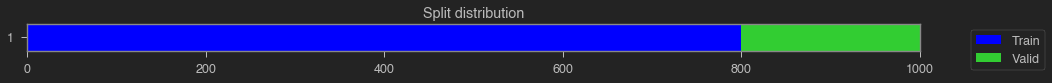

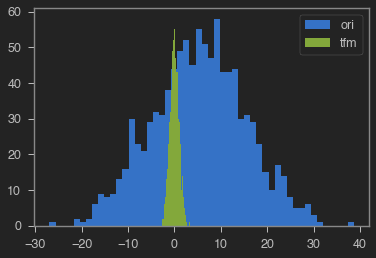

In [ ]:
# Standardize
from tsai.data.validation import TimeSplitter
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(StandardScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

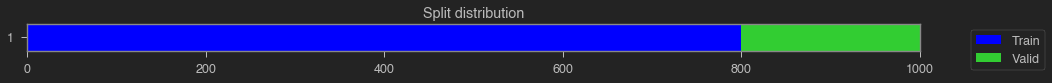

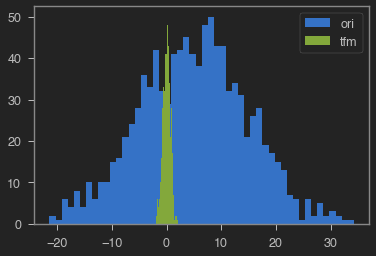

In [ ]:
# RobustScaler
y = random_shuffle(np.random.randn(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(RobustScaler)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

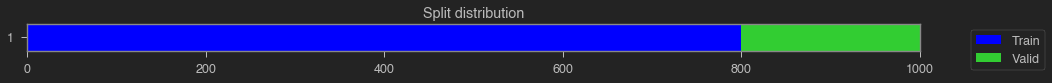

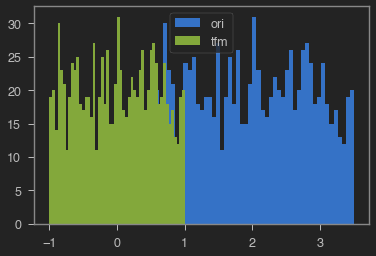

In [ ]:
# Normalize
y = random_shuffle(np.random.rand(1000) * 3 + .5)
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(Normalizer)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

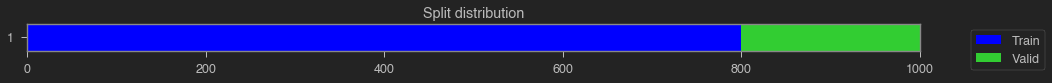

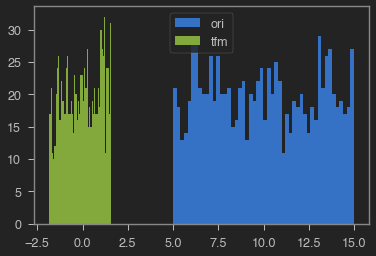

In [ ]:
# BoxCox
y = random_shuffle(np.random.rand(1000) * 10 + 5)
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(BoxCox)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

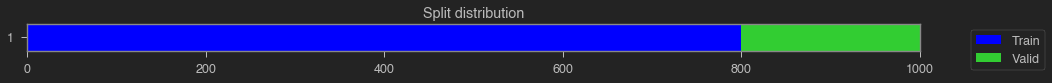

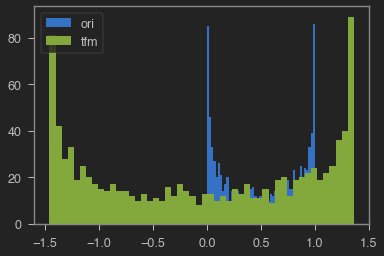

In [ ]:
# YeoJohnshon
y = random_shuffle(np.random.randn(1000) * 10 + 5)
y = np.random.beta(.5, .5, size=1000)
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(YeoJohnshon)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

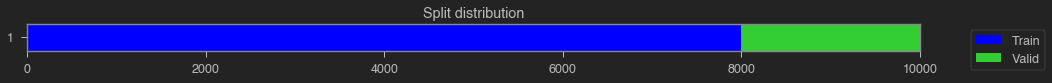

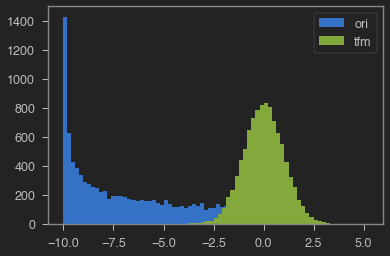

In [ ]:
# QuantileTransformer
y = - np.random.beta(1, .5, 10000) * 10
splits = TimeSplitter()(y)
preprocessor = TargetTransformer(Quantile)
preprocessor.fit(y[splits[0]])
y_tfm = preprocessor.transform(y)
test_close(preprocessor.inverse_transform(y_tfm), y, 1e-1)
plt.hist(y, 50, label='ori',)
plt.hist(y_tfm, 50, label='tfm')
plt.legend(loc='best')
plt.show()

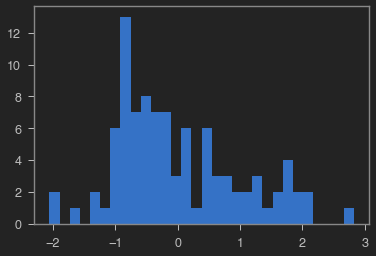

In [ ]:
from tsai.data.external import *
X,y,splits = get_regression_data('AppliancesEnergy', split_data=False)
std_tfm = TargetTransformer(StandardScaler)
std_tfm.fit(y[splits[0]])
y_tfm = std_tfm.transform(y)
tfms = [None, TSRegression()]
dls = get_ts_dls(X,y_tfm,splits=splits, tfms=tfms, bs=512)
xb,yb=first(dls.train)
yb.min(), yb.max()
plt.hist(yb.numpy(), 30)
test_close(std_tfm.inverse_transform(y_tfm), y)

In [ ]:
#export
def ReLabeler(cm):
    r"""Changes the labels in a dataset based on a dictionary (class mapping) 
        Args:
            cm = class mapping dictionary
    """
    def _relabel(y):
        obj = len(set([len(listify(v)) for v in cm.values()])) > 1
        keys = cm.keys()
        if obj: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y], dtype=object).reshape(*y.shape)
        else: 
            new_cm = {k:v for k,v in zip(keys, [listify(v) for v in cm.values()])}
            return np.array([new_cm[yi] if yi in keys else listify(yi) for yi in y]).reshape(*y.shape)
    return _relabel

In [ ]:
vals = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}
y = np.array([vals[i] for i in np.random.randint(0, 5, 20)])
labeler = ReLabeler(dict(a='x', b='x', c='y', d='z', e='z'))
y_new = labeler(y)
test_eq(y.shape, y_new.shape)
y, y_new

(array(['a', 'e', 'b', 'a', 'd', 'd', 'b', 'd', 'e', 'a', 'e', 'e', 'b',
        'b', 'b', 'b', 'e', 'c', 'd', 'a'], dtype='<U1'),
 array(['x', 'z', 'x', 'x', 'z', 'z', 'x', 'z', 'z', 'x', 'z', 'z', 'x',
        'x', 'x', 'x', 'z', 'y', 'z', 'x'], dtype='<U1'))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.Re